# Image Captioning using Deep Learning: Assignment-2

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any pre-written cells below, just make sure to properly explain your work in Markdown and don't change the dataset**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [99]:
import torch
torch.manual_seed(0)
import numpy as np
np.random.seed(0)
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Compose, ToTensor

## Load *Dataset*
**DON'T CHANGE THIS CODE**.

In [100]:
import torchvision
from torchvision import transforms, datasets

train = datasets.MNIST('', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))

test = datasets.MNIST('', train=False, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor()
                       ]))




# Your Code from here...

In [101]:
# load the data set

X = train.data
y = train.targets

# normalize the dataset, won't be doing it here in later assignments
X = X.float() / 255
test.data=test.data.float()/255

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, val_index in split.split(X,y):
  X_train, X_test = X[train_index], X[val_index]
  y_train, y_test = y[train_index], y[val_index]


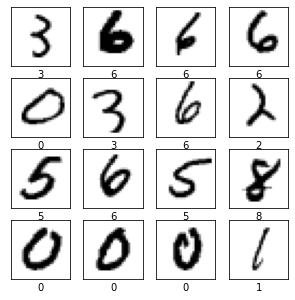

In [102]:
#display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
np.random.seed(0)
indices = np.random.choice(len(train), size=16, replace=False)

# Get the images and labels for these indices
images = [ToPILImage()(train[i][0]) for i in indices]
labels = [train[i][1] for i in indices]

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(5,5))

# Display the images
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i], cmap='binary')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel(labels[i])

plt.show()


In [103]:
# define your dataset for pre-processing into Neural Network

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))
test_dataset = TensorDataset(test.data, test.targets)

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)




<ipython-input-103-a7a31e875935>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float), torch.tensor(y_train, dtype=torch.long))
<ipython-input-103-a7a31e875935>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float), torch.tensor(y_test, dtype=torch.long))


## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [104]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x





## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [105]:
def train(model, optimizer, criterion, train_loader, display_step=None):
    nb=10
    for epoch in range(nb):
      for batch in train_loader:
        inputs,labels=batch

        b=inputs.size(0)
        inputs=inputs.view(b,-1)

        optimizer.zero_grad()

        outputs=model(inputs)

        loss=criterion(outputs,labels)

        loss.backward()

        optimizer.step()






## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [106]:
def predict(model, X_test):
  
  # Convert the input data to a PyTorch tensor
  X_test = torch.from_numpy(X_test)
  
  # Use the model's eval method to turn off dropout and other training-specific features
  model.eval()
  
  # Use the model's forward method to get the predictions for the input data
  with torch.no_grad():
      output = model(X_test)
  
  # Get the index of the maximum class probability for each sample
  _, predictions = torch.max(output, dim=1)
  
  # Convert the predictions to a NumPy array
  predictions = predictions.numpy()
  
  return predictions


In [107]:
def accuracy(pred, labels):
    labels = np.array(labels)

    correct_predictions = np.sum(pred == labels)

    acc = correct_predictions / len(pred)*100

    return acc

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [92]:
final_model=Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(final_model.parameters(), lr=0.01, momentum=0.9)

train(final_model, optimizer, criterion, train_loader, display_step=None)

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [93]:

X_test_np = X_test.numpy()
a=predict(final_model,X_test_np)
c=accuracy(a,y_test)
print("Final Prediction ",c)



Final Prediction  97.78333333333333


In [94]:
# X_test_np2 = test.data.numpy()
# a2=predict(final_model,X_test_np2)
# c2=accuracy(a2,test.targets)
# print("Final Prediction ",c2)

In [95]:
  # a

In [96]:
# x2=np.array(y_test)
# x2

## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [97]:
from google.colab import files
torch.save(final_model, 'ass_2.pt')
files.download('ass_2.pt') # download the file from the Colab session for submission

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Check if it got saved right!

In [98]:
# load the model, use predict function

model2 = torch.load('ass_2.pt')
X_test_np2 = X_test.numpy()
predi=predict(model2,X_test_np2)
val=accuracy(predi,y_test)
print("Final Prediction ",val)



Final Prediction  97.78333333333333
